<a href="https://colab.research.google.com/github/bhogasena/BikeSharingDemad/blob/main/Bike_Sharing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing Demand Prediction and Interpretation using Linear Regression

## Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

Compnay wants to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market.

The company wants to know:

*   Which variables are significant in predicting the demand for shared bikes.
*   How well those variables describe the bike demands




## Step 1: Reading and Understanding the Data

In [44]:
import numpy as np
import pandas as pd
import sklearn
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.graph_objects as go
import warnings
pd.options.display.max_columns=None


In [45]:
bike_df = pd.read_csv("day.csv")
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [46]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [47]:
bike_df.dteday = pd.to_datetime(bike_df.dteday)
bike_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [48]:
bike_df.drop(['instant','dteday','casual','registered'],inplace=True,axis=1)

In [49]:
bike_df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


## Step 2: Visualising the Data

### Quantitative Continuous Variables Analysis using scatter plot

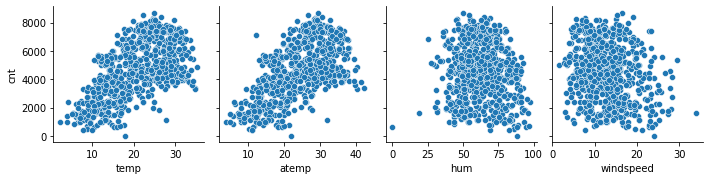

In [50]:
cont_vars = ['temp','atemp','hum','windspeed']
dep_vars=['cnt']
sns.pairplot(bike_df,x_vars=cont_vars,y_vars=dep_vars)
plt.show()

#### Observations

As per above plots, there seems to be linear relationship for temperature and feeling temperature with total rental bikes

In [51]:
desc_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
def create_box_plot(x_var,y_var,row,col,title,bins):
  tr1 = go.Histogram(x=bike_df[x_var],y=bike_df[y_var],histfunc='sum')
  tr1.update(name=title)
  fig.add_trace(tr1,row,col)
  fig.update_xaxes(title={
        'text': title},row=row,col=col)

fig = make_subplots(3,3,shared_yaxes=True)
create_box_plot('season','cnt',1,1,'Season',{'start':1,'end':4,'size':1})
create_box_plot('yr','cnt',1,2,'Year',{'start':0,'end':2,'size':1})
create_box_plot('mnth','cnt',1,3,'Month',{'start':1,'end':12,'size':1})
create_box_plot('holiday','cnt',2,1,'Holiday',{'start':0,'end':1,'size':1})
create_box_plot('weekday','cnt',2,2,'Weekday',{'start':0,'end':6,'size':1})
create_box_plot('workingday','cnt',2,3,'Workingday',{'start':0,'end':1,'size':1})
create_box_plot('weathersit','cnt',3,1,'Weathersit',{'start':1,'end':4,'size':1})

fig.update_layout(width=1200,height=1200,barmode='group', bargap=0.15)
fig.update_yaxes(title={'text':"Total Bikes Rented"},row=1,col=1)
fig.show()

#### Observations

*   Summer and fall seasons have more bikes rented compared to spring and winter
*   Seems bikes rentals increases year by year
*   May to September months have higher bike rentals compared to other months
*   Seems non-holidays have more bike rentals compared to holdiays.
*   There seems to be no significance difference on weekdays.
*   Working days have higher bike rentals.
*   Clear weather have higher bike rentals

## Step 3: Data Preparation

In [52]:
bike_df = pd.get_dummies(bike_df,columns=['season','mnth','weathersit','weekday'],prefix=["Season","Month","weathersit","Weekday"],drop_first=True)


In [53]:
bike_df.rename(columns={"Season_2":"isSummer","Season_3":"isFall","Season_4":"isWinter","Year_1":"Year_2019","weathersit_2":"Mist","weathersit_3":"Light_Snow_Rain"},inplace=True)

In [54]:
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,isSummer,isFall,isWinter,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Mist,Light_Snow_Rain,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Step 4: Splitting the Data into Training and Testing Sets

In [55]:
np.random.seed(1)
bike_train_df, bike_test_df = train_test_split(bike_df,train_size=0.7, test_size=0.3, random_state=100)

### Rescaling the Features 

In [56]:
scalar = MinMaxScaler()
scalar_cols = ['temp','atemp','hum','windspeed','cnt']
scalar.fit(bike_train_df[scalar_cols])
bike_train_df[scalar_cols] = scalar.transform(bike_train_df[scalar_cols])
bike_train_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,isSummer,isFall,isWinter,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Mist,Light_Snow_Rain,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [57]:
px.imshow(bike_train_df[['temp','atemp','cnt','hum','windspeed']].corr(),text_auto=True)

#### Observations

*   Temperature and feeling temperature are highly correlated. We see VIFs in later sections below
*   As feeling tempeterature ('atemp')  is correlated with bike rentals we start with this variable first to build a model



## Step 5: Building a linear model

In [58]:
y_train = bike_train_df.pop('cnt')
X_train = bike_train_df

In [59]:
def linear_model(x_vars):
  X_train_lm = sm.add_constant(X_train[x_vars])
  lr = sm.OLS(y_train, X_train_lm).fit()
  print(lr.summary())


In [60]:
linear_model(['atemp'])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           1.10e-61
Time:                        11:44:45   Log-Likelihood:                 176.51
No. Observations:                 510   AIC:                            -349.0
Df Residuals:                     508   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.020      8.199      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [61]:
linear_model(['temp','atemp'])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     182.5
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           1.95e-60
Time:                        11:44:45   Log-Likelihood:                 176.81
No. Observations:                 510   AIC:                            -347.6
Df Residuals:                     507   BIC:                            -334.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1634      0.020      8.215      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



#### Observations


*   We can clearly see that when we add feeling temperature('atemp') though R2 increased very slightly  F-Static value decreased significantly. That means overall model is not good fit.
*   We can obviously see the P- value of temp is greater than significane level we need to remove this from our model. Let's also see VIF as we saw in correlation matrix temp and atemp are highly correlated.



In [62]:
def get_vif():
  vif = pd.DataFrame()
  vif['features'] = X_train.columns
  vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [63]:
get_vif()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars



           features     VIF
24        Weekday_2     inf
2        workingday     inf
23        Weekday_1     inf
27        Weekday_5     inf
26        Weekday_4     inf
25        Weekday_3     inf
1           holiday     inf
3              temp  447.70
4             atemp  383.54
5               hum   20.79
8            isFall   15.42
16          Month_8   11.01
9          isWinter   10.93
15          Month_7    9.62
7          isSummer    8.88
14          Month_6    7.35
17          Month_9    7.34
13          Month_5    7.16
18         Month_10    6.64
19         Month_11    5.99
12          Month_4    5.64
6         windspeed    4.71
20         Month_12    3.78
11          Month_3    3.06
21             Mist    2.21
0                yr    2.09
28        Weekday_6    1.93
10          Month_2    1.71
22  Light_Snow_Rain    1.23


#### Observation


*   'temp' variable VIF is also highest among all variables.



In [64]:
## Add one more variable 'hum'
linear_model(['atemp','hum'])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     205.3
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           4.74e-66
Time:                        11:46:33   Log-Likelihood:                 189.81
No. Observations:                 510   AIC:                            -373.6
Df Residuals:                     507   BIC:                            -360.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3217      0.036      8.910      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [65]:
## Add one more variable 'windspeed'
linear_model(['atemp','hum','windspeed'])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     152.1
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           2.90e-70
Time:                        11:47:11   Log-Likelihood:                 202.43
No. Observations:                 510   AIC:                            -396.9
Df Residuals:                     506   BIC:                            -379.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4520      0.044     10.357      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [68]:
X_train.drop(['temp'],axis=1,inplace=True)

In [69]:
get_vif()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars



           features    VIF
23        Weekday_2    inf
24        Weekday_3    inf
2        workingday    inf
22        Weekday_1    inf
25        Weekday_4    inf
26        Weekday_5    inf
1           holiday    inf
3             atemp  40.32
4               hum  20.66
7            isFall  15.33
8          isWinter  10.92
15          Month_8  10.22
14          Month_7   9.06
6          isSummer   8.88
16          Month_9   7.07
12          Month_5   6.82
13          Month_6   6.79
17         Month_10   6.55
18         Month_11   5.97
11          Month_4   5.56
5         windspeed   4.44
19         Month_12   3.78
10          Month_3   2.99
20             Mist   2.20
0                yr   2.08
27        Weekday_6   1.93
9           Month_2   1.71
21  Light_Snow_Rain   1.23


In [70]:
### Adding All variables to Model
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          4.12e-180
Time:                        11:52:24   Log-Likelihood:                 523.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     482   BIC:                            -873.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1754      0.031     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [71]:
X_train.drop(['Weekday_4'],axis=1,inplace=True)


In [72]:
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          4.12e-180
Time:                        11:54:32   Log-Likelihood:                 523.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     482   BIC:                            -873.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1754      0.031     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [73]:
X_train.drop(['Weekday_3'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     106.0
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          4.20e-181
Time:                        11:55:26   Log-Likelihood:                 523.78
No. Observations:                 510   AIC:                            -993.6
Df Residuals:                     483   BIC:                            -879.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1752      0.031     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [74]:
X_train.drop(['Month_12'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     110.3
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          5.12e-182
Time:                        11:55:56   Log-Likelihood:                 523.50
No. Observations:                 510   AIC:                            -995.0
Df Residuals:                     484   BIC:                            -884.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1783      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [75]:
X_train.drop(['Month_11'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     115.1
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          5.01e-183
Time:                        11:56:22   Log-Likelihood:                 523.44
No. Observations:                 510   AIC:                            -996.9
Df Residuals:                     485   BIC:                            -891.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1783      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [76]:
X_train.drop(['Weekday_5'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     120.2
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          6.07e-184
Time:                        11:56:47   Log-Likelihood:                 523.13
No. Observations:                 510   AIC:                            -998.3
Df Residuals:                     486   BIC:                            -896.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1789      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [77]:
X_train.drop(['holiday'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.7
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          8.23e-185
Time:                        11:57:24   Log-Likelihood:                 522.67
No. Observations:                 510   AIC:                            -999.3
Df Residuals:                     487   BIC:                            -901.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1743      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [78]:
X_train.drop(['Month_7'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.5
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.34e-185
Time:                        11:58:00   Log-Likelihood:                 522.00
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     488   BIC:                            -906.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1735      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [79]:
X_train.drop(['Weekday_2'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     137.8
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          2.50e-186
Time:                        11:58:48   Log-Likelihood:                 521.16
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     489   BIC:                            -911.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1749      0.030     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [80]:
X_train.drop(['Month_2'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     144.9
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          4.37e-187
Time:                        11:59:14   Log-Likelihood:                 520.36
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     490   BIC:                            -916.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1839      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [81]:
X_train.drop(['Month_4'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     152.2
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.32e-187
Time:                        11:59:32   Log-Likelihood:                 518.97
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     491   BIC:                            -919.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1874      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [82]:
X_train.drop(['Month_6'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.4
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          4.06e-188
Time:                        12:00:01   Log-Likelihood:                 517.53
No. Observations:                 510   AIC:                            -999.1
Df Residuals:                     492   BIC:                            -922.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1867      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [83]:
X_train.drop(['Weekday_1'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.5
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.48e-188
Time:                        12:00:22   Log-Likelihood:                 515.89
No. Observations:                 510   AIC:                            -997.8
Df Residuals:                     493   BIC:                            -925.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1857      0.029     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [84]:
get_vif()

           features    VIF
2             atemp  23.33
3               hum  17.42
6            isFall   8.22
1        workingday   4.60
4         windspeed   3.90
5          isSummer   3.68
7          isWinter   3.15
13             Mist   2.14
0                yr   2.05
10          Month_8   1.86
15        Weekday_6   1.81
9           Month_5   1.68
12         Month_10   1.64
11          Month_9   1.50
8           Month_3   1.33
14  Light_Snow_Rain   1.20


In [85]:
X_train.drop(['atemp'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     122.7
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.17e-155
Time:                        12:01:37   Log-Likelihood:                 434.51
No. Observations:                 510   AIC:                            -837.0
Df Residuals:                     494   BIC:                            -769.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2570      0.033     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [86]:
get_vif()

           features    VIF
2               hum  12.16
1        workingday   4.57
3         windspeed   3.88
5            isFall   3.61
6          isWinter   2.90
4          isSummer   2.51
0                yr   1.99
12             Mist   1.97
9           Month_8   1.85
14        Weekday_6   1.80
8           Month_5   1.64
11         Month_10   1.57
10          Month_9   1.50
7           Month_3   1.32
13  Light_Snow_Rain   1.14


In [87]:
X_train.drop(['hum'],axis=1,inplace=True)
linear_model(X_train.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     131.2
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          2.21e-156
Time:                        12:02:27   Log-Likelihood:                 433.69
No. Observations:                 510   AIC:                            -837.4
Df Residuals:                     495   BIC:                            -773.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2220      0.019     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [88]:
get_vif()

           features   VIF
1        workingday  3.79
2         windspeed  3.40
4            isFall  3.06
3          isSummer  2.33
5          isWinter  2.33
0                yr  1.94
8           Month_8  1.85
13        Weekday_6  1.64
7           Month_5  1.60
10         Month_10  1.57
11             Mist  1.55
9           Month_9  1.49
6           Month_3  1.29
12  Light_Snow_Rain  1.10
